# SWMM5 Culvert Sensitivity Analysis

Refer to [my notebook](https://github.com/mel-meng/SewerAnalysis/blob/master/examples/culvert/2%20SWMM5%20Culvert%20theory.ipynb) for more information on the swmm5 culvert theory.

In this notebook I will use DG 1.3.1 from HDS5 to see which parameters will impact the SWMM5 results.

## DG 1.3.1

I setup a HECRAS model for HDS design example 1.3.1, it can be found at : **./data/dj131.prj**.

Comparing with HY8, setting up a HECRAS model takes a lot more effort.

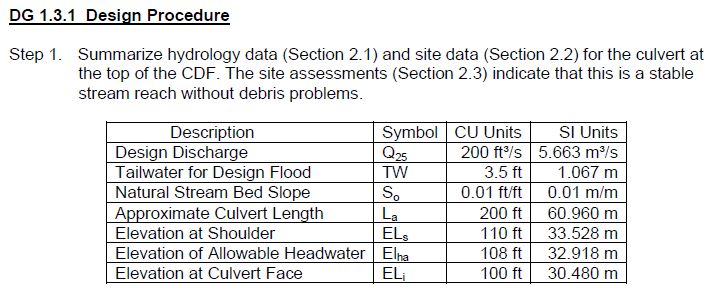

# Model Setup

A SWMM5 model is created to compare the performance curve.

Model: **./data/swmm/dg131.inp

- For the culvert, I didn't set any losses, entering the culvert code should handle all these automatically.
- I loaded a hydrograph from 300-0 cfs in 6 hours at node '4'.
- The depth vs total inflow in node '4' should give the performance curve
- added 3.5ft tail water at outlet
- pipe 2->3 is a big box pipe of 50ft wide to simulate the channel downstream

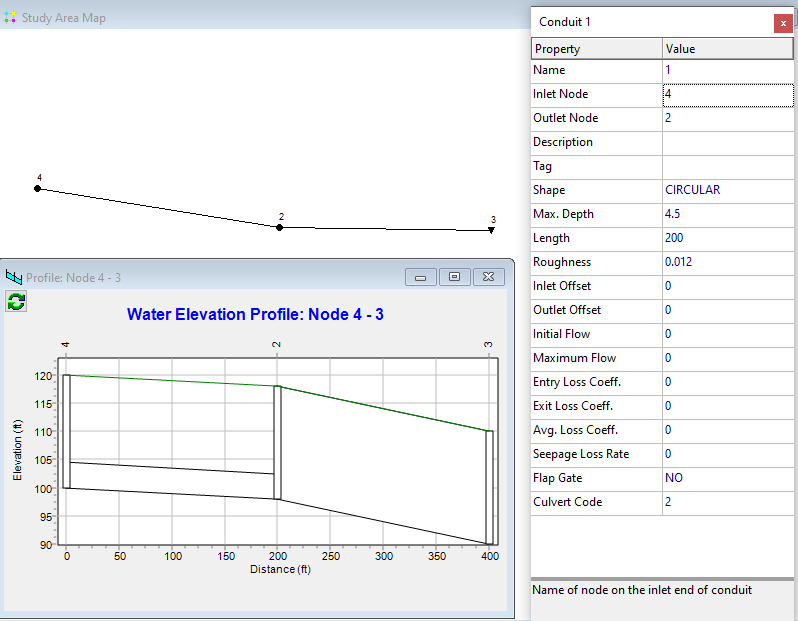

SWMM5 gives an answer of 7.93 ft for headwater depth, within 10% to HY8 result of 8.61ft.

A few things should be noted,

- For inlet control, SWMM5 shouldn't use the entrance/exit losses since the culvert routine doesn't rely on them for a correct calculation, also there is a single straight line water level. So the HGL will looks very different from the HGL from  HY8
- It is not recommended to divide the culvert into smaller pieces to more accurately account for the water surface, because the way the HDS5 calculation is implemented in SWMM5, the goal is not to accurately get the water surface right, the goal is to get the inlet headwater right. See this [thread](https://www.openswmm.org/Topic/9038/culvert-inlet-loss-comparing-hy-8-to-swmm) for more details.


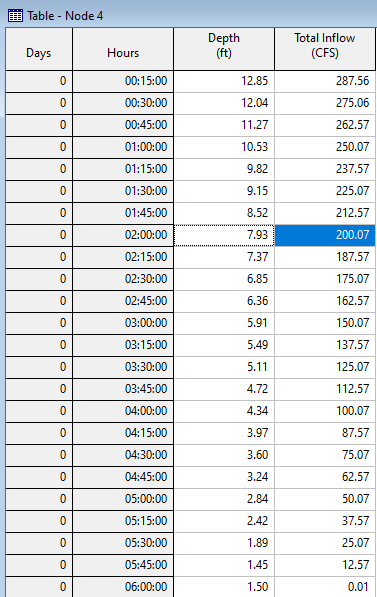

# Sensitivity Analysis

SWMM5 uses a unsteady state simulation, so the upstream/downstream condition can play more important role since it can introduce stability issues. Also I don't quite understand how the outlet control situation is handled since SWMM5 doesn't use FWHA equations at all.

- entrance/exit losses: LOSS1 ken=0.5 AND kex=1, lOSS2: ken=0.2 and kex=2
- downstream condition, to simulate channel expansion using a small pipe vs using a big pipe, BOX5 and BOX 50
- upstream condition, to simulate ponding condition using a node vs using a storage, NODE and STORAGE

In [1]:
from swmm.output import output as smo
import pandas as pd
import datetime
from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt

def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()
    

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_node(out_path, node_name):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)
    node_index = 0
    while True:
        if smo.getelementname(handle, smo.ElementType.NODE, node_index) == node_name:
            break
        node_index += 1
    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.NODE, node_index))

    # get the time sereis from the out file
    depth = smo.getnodeseries(handle, node_index, smo.NodeAttribute.INVERT_DEPTH, 0, num_steps)
    q = smo.getnodeseries(handle, node_index, smo.NodeAttribute.TOTAL_INFLOW, 0, num_steps)
    df = pd.DataFrame({'swmm5': depth, 'q': q}, index=timestep)
    return df



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_performance_curve(hy8_curve_csv, swmm5_out, xpswmm_csv, node_name):
    df = pd.read_csv(hy8_curve_csv)
    df_swmm = extract_node(swmm5_out, node_name)
    df_xp = pd.read_csv(xpswmm_csv)
    ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
    ax = df.plot(x='q', y='outlet', label='Outlet', style='.-', ax=ax)
    ax = df_swmm.plot(x='q', y='swmm5', label='SWMM5', style='o-', ax=ax)
    ax.fill_between(df_swmm['q'], df_swmm['swmm5']*0.9, df_swmm['swmm5']*1.1, alpha=0.2)
    ax = df_xp.plot(x='q', y='xpswmm', label='XPSWMM', style='o-', ax=ax)
    plt.xlabel('Discharge(cfs)')
    plt.ylabel('Headwater(ft)')
    plt.title('SWMM5 culvert vs HY8')
    plt.grid(True)
    plt.show()
    

# Compare

You need to update the path to each file in the code block below. Run it and it will plot the results.

In [3]:
import os
ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data"
swmm_inp = os.path.join(ws, 'swmm5/dg131_storage_node.inp')

swmm_out = os.path.join(ws, 'swmm5/dg131_storage_node.out')
run(swmm_inp)
df_storage = extract_node(swmm_out, node_name='1')
print(df)

swmm_inp = os.path.join(ws, 'swmm5/dg131.inp')
swmm_out = os.path.join(ws, 'swmm5/dg131.out')
run(swmm_inp)
df_node = extract_node(swmm_out, node_name='4')


... SWMM Version 5.3.0.dev0
... Run Complete1


NameError: name 'df' is not defined

In [4]:
import os
ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data"


results = {}
scenarios = ['e02x0', 'e05x0', 'e1x0', 'e0x05', 'e0x1', 'e0x2', 'e02x1']
# scenarios = ['loss1', 'loss2', 'loss3']
for sc in scenarios: 
    swmm_inp = os.path.join(ws, 'swmm5/dg131_%s.inp' % sc)
    swmm_out = os.path.join(ws, 'swmm5/dg131_%s.out' % sc)
    run(swmm_inp)
    results[sc] = extract_node(swmm_out, node_name='4')
    print(sc)
    print(results[sc])




... SWMM Version 5.3.0.dev0
... Run Complete4
e02x0
                         swmm5           q
2020-05-28 00:00:00  12.853357  287.562897
2020-05-28 00:15:00  12.041612  275.064728
2020-05-28 00:30:00  11.265922  262.566406
2020-05-28 00:45:00  10.526278  250.067749
2020-05-28 01:00:00   9.822718  237.569382
2020-05-28 01:15:00   9.154978  225.069427
2020-05-28 01:30:00   8.523647  212.569427
2020-05-28 01:45:00   7.928207  200.069427
2020-05-28 02:00:00   7.368853  187.569427
2020-05-28 02:15:00   6.845573  175.069427
2020-05-28 02:30:00   6.358367  162.569427
2020-05-28 02:45:00   5.907237  150.069427
2020-05-28 03:00:00   5.492122  137.569427
2020-05-28 03:15:00   5.106722  125.069427
2020-05-28 03:30:00   4.722830  112.569427
2020-05-28 03:45:00   4.342566  100.069427
2020-05-28 04:00:00   3.967034   87.569427
2020-05-28 04:15:00   3.599984   75.069427
2020-05-28 04:30:00   3.237018   62.569431
2020-05-28 04:45:00   2.842197   50.069431
2020-05-28 05:00:00   2.417089   37.569431
2

In [5]:
swmm_inp = os.path.join(ws, 'swmm5/dg131.inp')
swmm_out = os.path.join(ws, 'swmm5/dg131.out')
run(swmm_inp)
results['base'] = extract_node(swmm_out, node_name='4')


... SWMM Version 5.3.0.dev0
... Run Complete4


# Losses Sensitivity Analysis


In [7]:
import plotly.graph_objects as go
fig = go.FigureWidget()
for sc in ['base'] + scenarios:
    df = results[sc]# .plot(x='q', y='swmm5', label=sc)
    if sc == 'e02x1':
        fig.add_trace(go.Scatter(
        x=df['q'], y=df['swmm5'],
        name = sc,
        line=dict(color='light blue', width=4, dash='dot')
    ))
    else:
        fig.add_trace(go.Scatter(
        x=df['q'], y=df['swmm5'],
        name = sc
#         line=dict(color='blue')
    ))

fig

FigureWidget({
    'data': [{'name': 'base',
              'type': 'scatter',
              'uid': '8c35e42e-1…

It looks that only when exit loss = 2 will push the curve upward significantly, all other settings seems to produce the same results. 

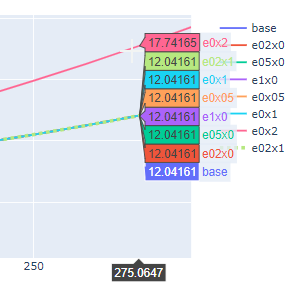

# Inlet Side Setting

Since the headwater is calculated as the water depth of the inlet node of the culvert, I would like to see what will impact its depth.

- base:loading directly to the inlet
- storage:loading directly to the inlet, which is modeled as a storage node
- channel: loading to a big channel which then flows into the inlet


... SWMM Version 5.3.0.dev0
... Run Complete1


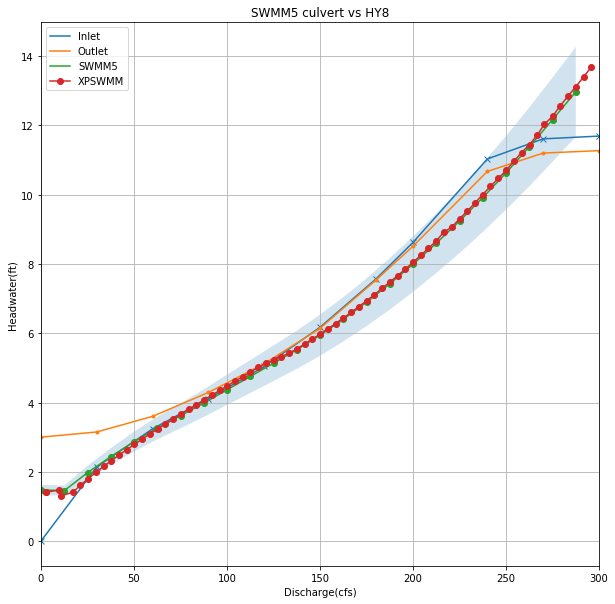

In [5]:
swmm5_out = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hds5_example2.out"
hy8_curve_csv = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hy8_performance_curve2.csv"
xpswmm_csv = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\xpswmm.csv"
import os

ws = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data"
swmm_inp = os.path.join(ws, 'swmm5/dg131_storage_node.inp')
swmm_out = os.path.join(ws, 'swmm5/dg131_storage_node.out')
hy8_curve_csv = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\hy8_performance_curve2.csv"
xpswmm_csv = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\culvert\data\xpswmm.csv"

run(swmm_inp)
compare_performance_curve(hy8_curve_csv, swmm_out, xpswmm_csv, node_name='1')
